In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt

## Trijunction shapes:

### Symmetric shapes
* Rectangular
* Circular
* Triangular with different $\theta$
* Ring
* Half ring
* V shape

### Asymmetric shapes
* Rectangle + triangle
* Rectangle + half ring

In [118]:
# Hamiltonian of the system
cavity_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu_cavity) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + B_x * kron(sigma_x, sigma_0)
"""
lead_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""

a = 1
cavity_template = kwant.continuum.discretize(cavity_hamiltonian, grid=a)
lead_template = kwant.continuum.discretize(lead_hamiltonian, grid=a)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

In [188]:
def rectangle_shape(L, W):
    def shape(site):
        return -L/2 <= site.pos[0] < L/2 and 0 <= site.pos[1] < W
    return shape


def triangle_shape(L, angle):
    def shape(site):
        x, y = site.pos
        if np.tan(angle)*x <= -(y-L) and np.tan(angle)*x >= (y-L) and y>=0:
            return True
    return shape


def circle_shape(r):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2
    return shape


def ring_shape(R, r):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 > r**2 and x**2 + y**2 < R**2
    return shape


def half_ring_shape(R, r):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 > r**2 and x**2 + y**2 < R**2 and y >= 0
    return shape


def v_shape(L, l, angle):
    def shape(site):
        x, y = site.pos
        if np.tan(angle)*x <= -(y-L) and np.tan(angle)*x >= (y-L) and y >= 0:
            if not (np.tan(angle)*x <= -(y-l) and np.tan(angle)*x >= (y-l)):
                return True
    return shape


def rectangle_triangle_shape(L, angle):

    rectangle = rectangle_shape(L, L)
    triangle = triangle_shape(L, angle)

    def shape(site):
        x, y = site.pos
        if x >= 0:
            return rectangle(site)
        else:
            return triangle(site)

    return shape
                              

def rectangle_ring_shape(L, r):

    rectangle = rectangle_shape(2*L, L)
    ring = half_ring_shape(L, r)

    def shape(site):
        x, y = site.pos
        if x >= 0:
            return rectangle(site)
        else:
            return ring(site)

    return shape    

In [189]:
def make_junction(f_shape, args, start=[0,0]):
    junction = kwant.Builder()
    junction.fill(
        cavity_template,
        shape=f_shape(*args),
        start=start
    )
    return junction


def make_leads(center, w=3):
    lead_top = kwant.Builder(symmetry=kwant.TranslationalSymmetry([0, a]))
    lead_bot_left = kwant.Builder(symmetry=kwant.TranslationalSymmetry([0, -a]))
    lead_bot_right = kwant.Builder(symmetry=kwant.TranslationalSymmetry([0, -a]))

    lead_top.fill(lead_template,
                  shape=lambda site: -w/2 <= site.pos[0] < w/2,
                  start=[0]);
    lead_bot_right.fill(lead_template,
                        shape=lambda site: -w/2 + center <= site.pos[0]  < w/2+center,
                        start=[center]);
    lead_bot_left.fill(lead_template,
                       shape=lambda site: -w/2 - center <= site.pos[0]  < w/2-center,
                       start=[-center]);

    return lead_bot_left, lead_bot_right, lead_top

In [195]:
wire_width = 5

L = 20
l = 12
W = 10
angle = np.pi/3
triangle_side = np.abs(L/np.tan(angle))-1
R = 14
r = 9

args = [
    [rectangle_shape, [L, W]],
    [triangle_shape, [L, angle]],
    [circle_shape, [R]],
    [ring_shape, [R, r], [R-1, 0]],
    [half_ring_shape, [R, r], [R-1, 0]],
    [v_shape, [L, l, angle], [triangle_side, 0]],
    [rectangle_ring_shape, [L, 16]],
    [rectangle_triangle_shape, [L, angle]]
]

centers = [
    W/2,
    triangle_side/2,
    R/2,
    R/2,
    R-wire_width/2,
    triangle_side-wire_width/2,
    L-wire_width/2,
    triangle_side/2
]   

In [196]:
junctions = []
for arg in args:
    junctions.append(make_junction(*arg))

In [197]:
leads = []
for center in centers:
    leads.append(make_leads(center))

In [198]:
i = 0
for junction in junctions:
    for lead in leads[i]:
        junction.attach_lead(lead)
    junction = junction.finalized()
    i += 1

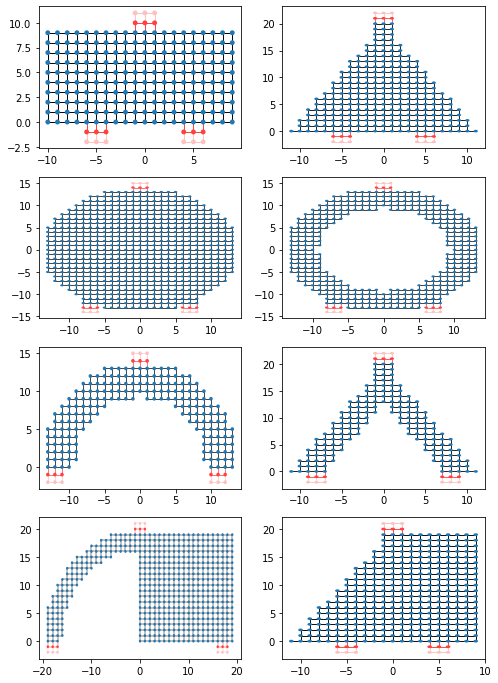

In [201]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(8, 12))
i = 0
for ax in axes.flatten():
    kwant.plot(junctions[i], ax=ax)
    i += 1
plt.savefig('shapes.svg')